# P–α Sweep Visualizations

基于 Plan C 标准差版本：枚举 $P_{avg}$ (125→200)，求最优 $lpha^*$，并绘制三种可视化模式。

**三种图像模式**
1. 3D 彩色轨迹（颜色=成本）
2. 3D 气泡散点（颜色+大小=成本）
3. 3D 丝带曲面（薄带显示轨迹）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from math import exp, sqrt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

print('Libraries imported successfully!')

Libraries imported successfully!


In [2]:
# ==================== Parameters (Plan C Std Version) ====================
M = 10**8
E_E_base = 179000 * 3
C_E = 2.2 * 10**5
F_E = 1.2 * 10**8
p_E = 0.03
sigma_swing = 1.5
theta_limit = 4.0
val_rep_E = 5 * 10**9

f_avg = 1472
C_R = 1.175 * 10**6
F_R = 5 * 10**7
q_R = 0.95
val_R = 7.5 * 10**6

ff = 1 - exp(-theta_limit**2 / (2 * sigma_swing**2))
E_E = E_E_base * ff
N = f_avg

# Sweep setup
P_range = np.arange(125, 201, 1)
alphas = np.linspace(0, 1, 10001)

# Weights (Scheme 2: 35:25:25:15)
w1, w2, w3, w4 = 0.35, 0.25, 0.25, 0.15

print('Parameters ready.')

Parameters ready.


In [3]:
def plan_C_stats_with_payload(alpha, P_payload):
    # === Elevator part ===
    if alpha > 0:
        E_T_E = alpha * M / (E_E * (1 - p_E))
        Var_T_E = alpha * M * p_E / (E_E * (1 - p_E)**2)
    else:
        E_T_E = 0
        Var_T_E = 0

    # === Rocket part ===
    if alpha < 1:
        E_T_R = (1 - alpha) * M / P_payload / (N * q_R)
        Var_T_R = (1 - q_R) * ((1 - alpha) * M)**2 / (N**3 * q_R**3 * P_payload**2)
    else:
        E_T_R = 0
        Var_T_R = 0

    E_T_C = max(E_T_E, E_T_R)
    Var_T_C = Var_T_E if E_T_E >= E_T_R else Var_T_R
    Std_T_C = sqrt(Var_T_C) if Var_T_C > 0 else 0

    # === Elevator cost ===
    if alpha > 0:
        E_C_E = (alpha * M * C_E +
                 alpha * M * F_E / E_E +
                 alpha * M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
        Var_C_E = (alpha**2 * M * p_E * val_rep_E**2 / (E_E * (1 - p_E)**2)) / 10**16
    else:
        E_C_E = 0
        Var_C_E = 0

    # === Rocket cost ===
    if alpha < 1:
        M_R = (1 - alpha) * M
        E_C_R = (M_R * C_R / q_R +
                 val_R * M_R * (1 - q_R) / (P_payload * q_R) +
                 M_R / (N * q_R * P_payload)) / 10**8
        Var_C_R = ((1 - alpha)**2 *
                   (C_R**2 * P_payload * M * (1 - q_R) / q_R**2 +
                    val_R**2 * M * (1 - q_R) / (P_payload * q_R**2) +
                    (1 - q_R) * M**2 / (N**3 * q_R**3 * P_payload**2))) / 10**16
    else:
        E_C_R = 0
        Var_C_R = 0

    E_C_C = E_C_E + E_C_R
    Var_C_C = Var_C_E + Var_C_R
    Std_C_C = sqrt(Var_C_C) if Var_C_C > 0 else 0

    return E_T_C, Std_T_C, E_C_C, Std_C_C

def normalize(arr):
    arr_min, arr_max = arr.min(), arr.max()
    if arr_max - arr_min < 1e-10:
        return np.zeros_like(arr)
    return (arr - arr_min) / (arr_max - arr_min)

# Sweep
alpha_opt_list = []
T_opt_list = []
C_opt_list = []

for P_payload in P_range:
    E_T_arr = []
    E_C_arr = []
    Std_T_arr = []
    Std_C_arr = []
    for alpha in alphas:
        E_T, Std_T, E_C, Std_C = plan_C_stats_with_payload(alpha, P_payload)
        E_T_arr.append(E_T)
        E_C_arr.append(E_C)
        Std_T_arr.append(Std_T)
        Std_C_arr.append(Std_C)

    E_T_arr = np.array(E_T_arr)
    E_C_arr = np.array(E_C_arr)
    Std_T_arr = np.array(Std_T_arr)
    Std_C_arr = np.array(Std_C_arr)

    E_T_norm = normalize(E_T_arr)
    E_C_norm = normalize(E_C_arr)
    Std_T_norm = normalize(Std_T_arr)
    Std_C_norm = normalize(Std_C_arr)
    scores = w1 * E_C_norm + w2 * E_T_norm + w3 * Std_C_norm + w4 * Std_T_norm

    best_idx = np.argmin(scores)
    alpha_opt_list.append(alphas[best_idx])
    T_opt_list.append(E_T_arr[best_idx])
    C_opt_list.append(E_C_arr[best_idx])

alpha_opt_list = np.array(alpha_opt_list)
T_opt_list = np.array(T_opt_list)
C_opt_list = np.array(C_opt_list)

print('Sweep complete.')

Sweep complete.


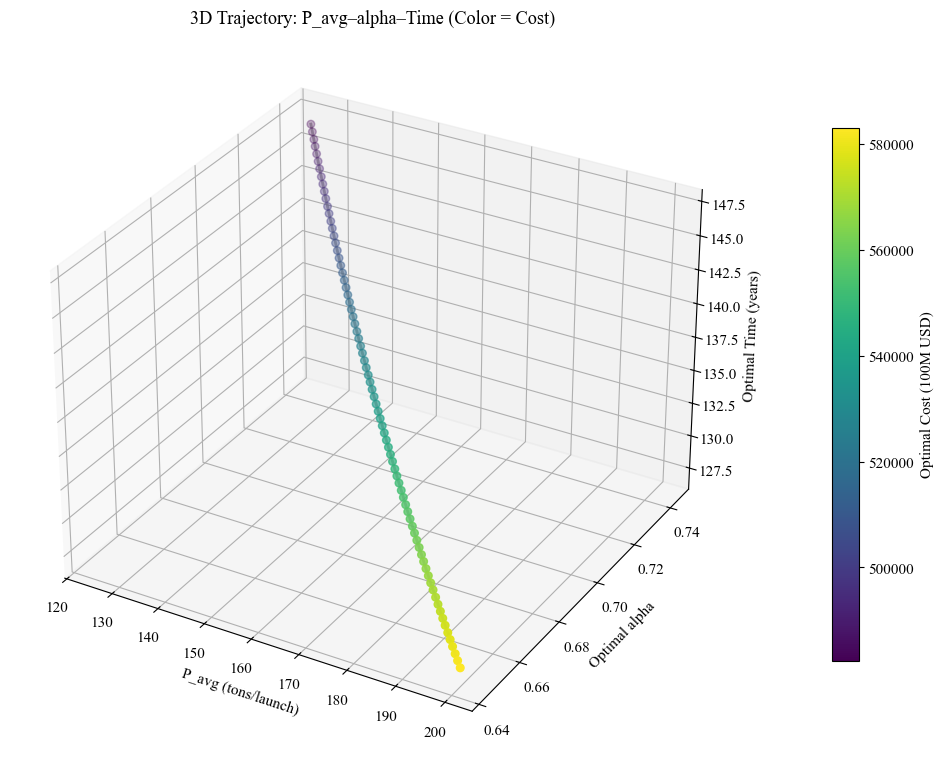

In [4]:
# ==================== Mode 1: 3D Colored Trajectory ====================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

norm = Normalize(vmin=C_opt_list.min(), vmax=C_opt_list.max())
colors = cm.viridis(norm(C_opt_list))

ax.plot(P_range, alpha_opt_list, T_opt_list, color='gray', linewidth=2, alpha=0.6)
ax.scatter(P_range, alpha_opt_list, T_opt_list, c=colors, s=30, depthshade=True)

ax.set_xlabel('P_avg (tons/launch)')
ax.set_ylabel('Optimal alpha')
ax.set_zlabel('Optimal Time (years)')
ax.set_title('3D Trajectory: P_avg–alpha–Time (Color = Cost)')

mappable = cm.ScalarMappable(norm=norm, cmap='viridis')
mappable.set_array(C_opt_list)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.1)
cbar.set_label('Optimal Cost (100M USD)')

plt.tight_layout()
plt.savefig('../results/p_alpha_mode1_3d_trajectory.png', dpi=300, bbox_inches='tight')
plt.show()

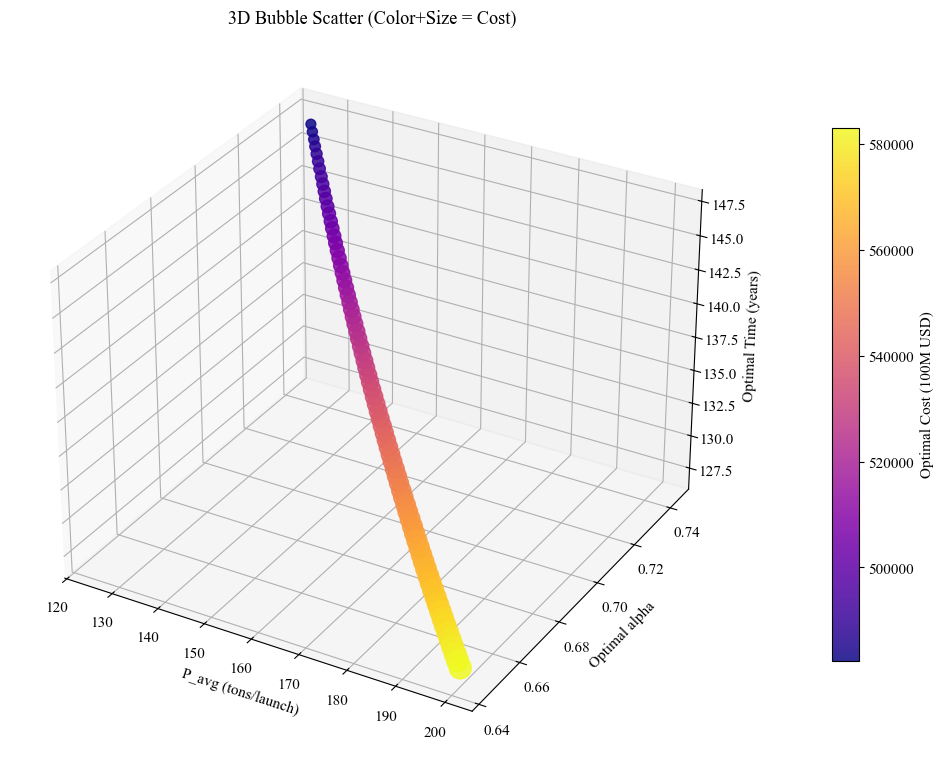

In [5]:
# ==================== Mode 2: 3D Bubble Scatter ====================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Bubble size scaled by cost
size = 50 + 200 * (C_opt_list - C_opt_list.min()) / (C_opt_list.max() - C_opt_list.min() + 1e-9)
sc = ax.scatter(P_range, alpha_opt_list, T_opt_list, c=C_opt_list, s=size, cmap='plasma', alpha=0.85)

ax.set_xlabel('P_avg (tons/launch)')
ax.set_ylabel('Optimal alpha')
ax.set_zlabel('Optimal Time (years)')
ax.set_title('3D Bubble Scatter (Color+Size = Cost)')

cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.1)
cbar.set_label('Optimal Cost (100M USD)')

plt.tight_layout()
plt.savefig('../results/p_alpha_mode2_3d_bubbles.png', dpi=300, bbox_inches='tight')
plt.show()

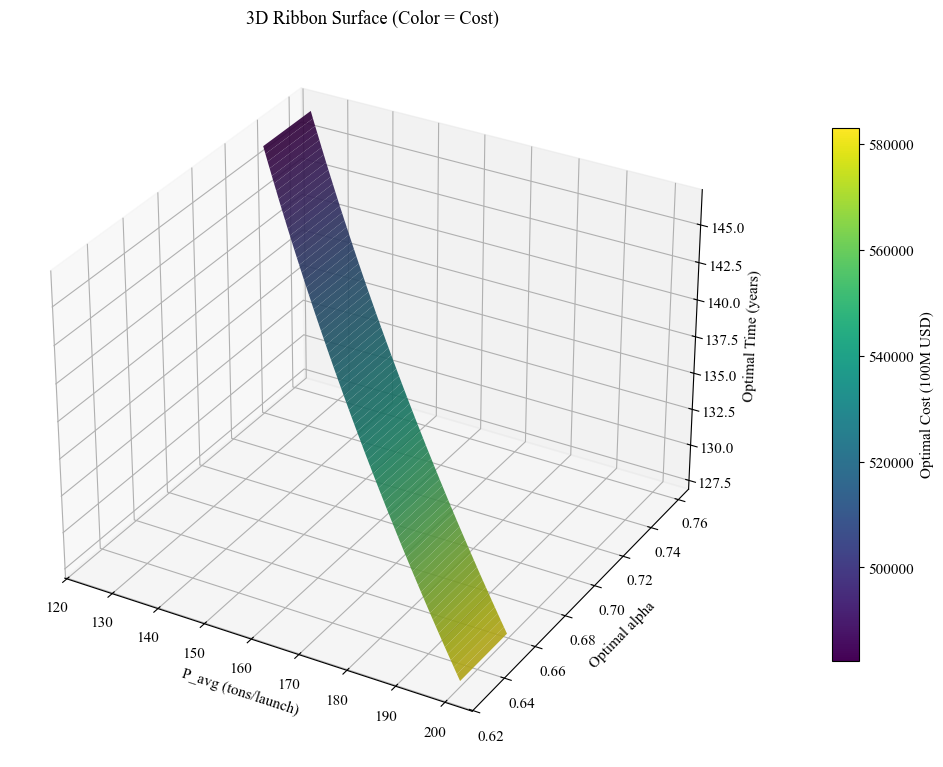

In [6]:
# ==================== Mode 3: 3D Ribbon Surface ====================
# Create a thin ribbon by offsetting alpha slightly
delta = 0.015
A1 = np.clip(alpha_opt_list - delta, 0, 1)
A2 = np.clip(alpha_opt_list + delta, 0, 1)

P_grid = np.vstack([P_range, P_range])
A_grid = np.vstack([A1, A2])
T_grid = np.vstack([T_opt_list, T_opt_list])
C_grid = np.vstack([C_opt_list, C_opt_list])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(P_grid, A_grid, T_grid, facecolors=cm.viridis(norm(C_grid)),
                       rstride=1, cstride=1, linewidth=0, antialiased=True, shade=True, alpha=0.9)

ax.set_xlabel('P_avg (tons/launch)')
ax.set_ylabel('Optimal alpha')
ax.set_zlabel('Optimal Time (years)')
ax.set_title('3D Ribbon Surface (Color = Cost)')

mappable = cm.ScalarMappable(norm=norm, cmap='viridis')
mappable.set_array(C_opt_list)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.1)
cbar.set_label('Optimal Cost (100M USD)')

plt.tight_layout()
plt.savefig('../results/p_alpha_mode3_3d_ribbon.png', dpi=300, bbox_inches='tight')
plt.show()